In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.nddata import CCDData

from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter

from astropy.table import Table, join

from scipy.signal import find_peaks
from scipy.optimize import fsolve

In [9]:
import re

# Function to extract numbers from the intensity column
def extract_intensity(value):
    if isinstance(value, str):
        match = re.search(r'\d+', value)  # Search for digits in the string
        if match:
            return float(match.group())  # Return the number if found
        else:
            return np.nan  # Replace non-numeric intensities like "b" with 0
    return value  # If it's already a number, return as is

# -------------------------------------------------------------------------

def get_wave_cal_from_df(df, deg, val, deriv=False):

    # Get poly function
    poly = np.polynomial.polynomial.polyfit(df['gaussian peaks'], df['lambda'], deg)

    # Get new values
    poly_val = np.polynomial.polynomial.polyval(val, poly)

    # If deriv is needed, return deriv
    if deriv:
        poly_deriv = np.polynomial.polynomial.polyder(poly)
        return poly_val, poly_deriv
    
    # Otherwise just values
    else:
        return poly_val

# -------------------------------------------------------------------------

# Function to get gaussian fit
def get_gaussian(y, x):

    """
    Gaussian function.
    """

    lmfitter = LevMarLSQFitter()
    guess = Gaussian1D(amplitude=y.max(), mean=np.mean(x), stddev=5)
    fit = lmfitter(model=guess, x=x, y=y)

    return fit

# -------------------------------------------------------------------------

def get_gaus_model(y, x):

    model = get_gaussian(y, x)
    mean = model.mean.value
    amp = model.amplitude.value

    return mean, amp

# -------------------------------------------------------------------------

def get_gaussian_peaks(spec, lams=False, lines=None):

    """
    Get gaussian peaks. This uses the information from scipy's peaks.
    
    """

    # Width of gaussian peaks
    width_scale = 5
    
    # Refine peaks with gaussian fitting
    new_peaks = []
    amplitudes = []
    fluxes = []

    peaks, _ = find_peaks(spec['flux'], prominence=5, height=5, distance=5)

    for p in peaks:

        y = np.asarray(spec['flux'][p-width_scale:p+width_scale])
        x = np.asarray(spec['pix'][p-width_scale:p+width_scale])

        if y.size == 0 or x.size == 0:

            print(p)
            new_peaks.append(np.nan)     
            amplitudes.append(np.nan)
            fluxes.append(np.nan)
            continue

        else:
            model = get_gaussian(y, x)

            new_peaks.append(np.float32(np.round(model.mean.value, 6)))
            amplitudes.append(np.float32(np.round(model.amplitude.value, 6)))

            sigma = np.float32(model.stddev.value)  # Standard deviation (width)
            amplitude = np.float32(model.amplitude.value)

            flux = np.float32(amplitude * sigma * np.sqrt(2 * np.pi))  # Area under the Gaussian
            flux = np.round(flux, 4)

            fluxes.append(flux)  # Append the flux for this peak

    id_lines = pd.DataFrame(peaks, columns=['peaks'])     
    id_lines['gaussian peaks'] = new_peaks
    id_lines['amplitudes'] = amplitudes
    id_lines['flux'] = fluxes

    return id_lines.dropna()

# -------------------------------------------------------------------------

# Crossmatching function within a specified range
def crossmatch(lines_peaks, nist_files, range_max=0.3):
    # Create a new dataframe for the result
    results = []
    note = []
    dups = []

    for i, row1 in lines_peaks.iterrows():

        lam_me = row1['lambda']
        
        # Find matches in df2 where y is within the range
        matched_rows = nist_files[(nist_files['obs_wl_air(A)'] >= lam_me - range_max) & 
                                  (nist_files['obs_wl_air(A)'] <= lam_me + range_max)]

        if not matched_rows.empty:
            # Append the first matched row to the results
            note.append('Match found')
            
            for _, row2 in matched_rows.iterrows():
                combined_row = pd.concat([row1, row2])
                results.append(combined_row)
            
            if len(matched_rows) > 1:

                dups.append('More found')

            else:
                dups.append('One found')

        else:
            note.append('No match found')
            dups.append('No match found')
    
    lines_peaks['note'] = note
    lines_peaks['duplicates?'] = dups

    # Combine results into a new dataframe
    return pd.DataFrame(results), lines_peaks

# -------------------------------------------------------------------------

# Function to choose the row based on given logic
def choose_row(group):
    
    # Step 1: If all values in intens are NaN, choose based on 'sp_num' and 'residual'
    if group['intens'].isnull().all():

        # Step 1.1: If all 'intens' values are NaN, choose the row with the smallest 'sp_num'
        min_d_group = group[group['sp_num'] == 1]
        
        # Step 1.2: If multiple rows are in neutral, choose the smallest residual
        if not min_d_group.empty:

            if len(min_d_group) > 1:
                return min_d_group.loc[min_d_group['residual'].idxmin()]
            else:
                return min_d_group.iloc[0]
        
        else:

            # If multiple rows for neutral don't exist, check for ionized
            min_d_group = group[group['sp_num'] == 2]

            # If multiple, choose smallest residual
            if len(min_d_group) > 1:
                return min_d_group.loc[min_d_group['residual'].idxmin()]
            else:
                return min_d_group.iloc[0]
            
    else:
        # Step 2: If 'intens' has non-NaN values, choose the row with the highest 'intens'
        return group.loc[group['intens'].idxmax()]

In [10]:
# Main dictionary for all files
lines = {
        'Cd': [],
        'Cs': [],
        'He': [],
        'Hg': [],
        # 'HgCd': []
        # 'HgCd-LLG300': [],
        'Zn': [],
        'HgAr': [],
        'Xe': []
        #  'FP': []
        }

In [11]:
# Get all of the lines in the dictonary

blue_df = []
green_df = []
filter = ['blue', 'green']


for key, l in lines.items():

    for n in range(2):

        # index = 0 and 1 raw spectra pix and column; 0 -> blue, 1 -> green
        l.append(pd.read_csv('spectra/spectra_{}_{}.csv'.format(key, filter[n])))

        lines_df = pd.read_csv('line_lists/old_list/neutral/fixed_neutral_{}_{}.csv'.format(key, filter[n]))

        # Transfer to new pandas
        lines_cat = lines_df[['Gaussian peaks', 'obs_wl_air(A)']].copy()
        lines_cat = lines_cat.rename(columns={'obs_wl_air(A)': 'lambda',
                                              'Gaussian peaks': 'gaussian peaks'})
        lines_cat['source'] = ['{}'.format(key)]*len(lines_df)

        if n == 0:
            blue_df.append(lines_cat)
        else:
            green_df.append(lines_cat)
            
blue = pd.concat(blue_df)
green = pd.concat(green_df)

In [ ]:
blue = blue.reset_index(drop=True).sort_values(by='gaussian peaks', ignore_index=True).drop_duplicates(subset=['gaussian peaks'])
green = green.reset_index(drop=True).sort_values(by='gaussian peaks', ignore_index=True).drop_duplicates(subset=['gaussian peaks'])

In [13]:
blue

,gaussian peaks,lambda,source
0,78.720986,3704.1655,Hg
1,348.058733,3790.0000,Hg
2,386.134628,3801.6583,Hg
3,443.273247,3819.6074,He
4,445.506180,3820.4000,Hg
...,...,...,...
84,5518.516610,5365.5000,Hg
85,5685.376680,5413.6145,Cs
86,5850.922576,5460.7500,HgAr
87,5850.980281,5460.7500,Hg


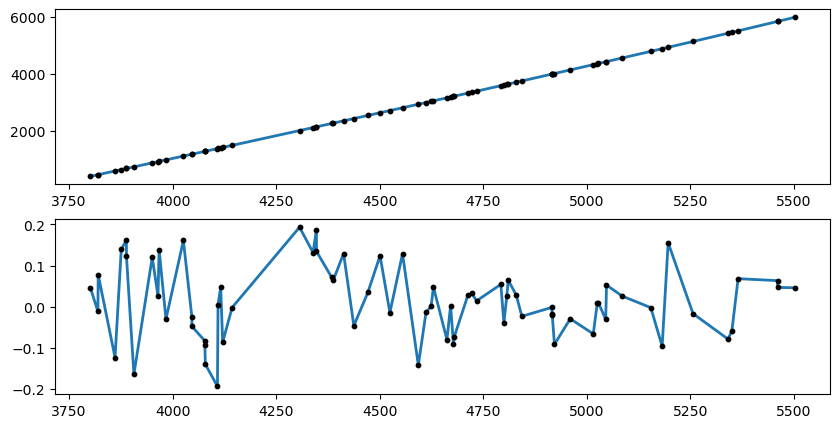

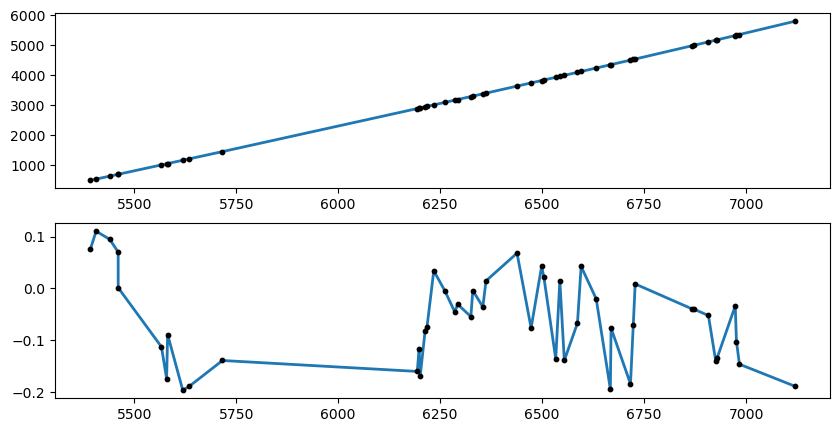

In [14]:
df = [blue, green]

for n in range(2):

    df_filter = df[n]
    df_filter['poly lambda'] = get_wave_cal_from_df(df_filter, 6, df_filter['gaussian peaks'].values)
    df_filter['residual'] = df_filter['lambda'] - df_filter['poly lambda']

    df_filter = df_filter[(df_filter['residual'] > -0.2) & (df_filter['residual'] < 0.2)]

    # print(len(df_filter))

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=[10,5])

    ax1.plot(df_filter['poly lambda'], df_filter['gaussian peaks'], linewidth=2)
    ax1.scatter(df_filter['poly lambda'], df_filter['gaussian peaks'], s=10, color='black', zorder=10)

    ax2.plot(df_filter['poly lambda'], df_filter['residual'], linewidth=2)
    ax2.scatter(df_filter['poly lambda'], df_filter['residual'], s=10, color='black', zorder=10)    

In [15]:
for key, l in lines.items():

    print(key)
    print('---')

    for n in range(2):

        # Call filter lines
        df_filter = df[n]

        # Only use sufficient residual 
        df_filter = df_filter[(df_filter['residual'] > -0.15) & (df_filter['residual'] < 0.15)]

        # Convert spectra from pix to lambda
        l[n]['lambda'] = get_wave_cal_from_df(df_filter, 6, l[n]['pix'].values)

        # Reassign gaussian peaks
        gaus_peaks = get_gaussian_peaks(l[n])
        gaus_peaks['lambda'] = get_wave_cal_from_df(df_filter, 6, gaus_peaks['gaussian peaks'])

        # index 2 and 3. 2 -> blue; 3 -> green
        l.append(gaus_peaks)

Cd
---
Cs
---


He
---


3


Hg
---


Zn
---


HgAr
---
Xe
---


In [16]:
for key, l in lines.items():
    
    all_in_arrays = []

    for n in range(2):

        nist_files = pd.read_csv('line_lists/NIST/{}_lines.txt'.format(key))
        gaus_peaks = l[n+2]

        # Processing dataframe
        # ---------------------
        results_lines, dup_notes = crossmatch(l[n+2], nist_files)
        results_lines = results_lines.drop(columns=['Aki(s^-1)', 'Acc', 'Type']) 

        # Convert intensity to numbers
        results_lines['intens'] = results_lines['intens'].apply(extract_intensity)
        results_lines['intens'] = pd.to_numeric(results_lines['intens'], errors='coerce')
        results_lines['residual'] = np.abs(results_lines['lambda'] - results_lines['obs_wl_air(A)'])

        # Systematic filtering
        filtered_results = results_lines.groupby(['peaks'], group_keys=False).apply(choose_row)
        filtered_results = filtered_results.reset_index(drop=True)

        # Combine filtered results with all gaus_peaks
        gaus_peaks_no_match = gaus_peaks[gaus_peaks['note'] == 'No match found']
        all_gaus_peaks = pd.concat([gaus_peaks_no_match, filtered_results]).sort_values(by=['peaks'])
        all_gaus_peaks = all_gaus_peaks[['peaks','gaussian peaks','amplitudes',
                                         'lambda','note','sp_num','obs_wl_air(A)']]
        # all_gaus_peaks.to_csv('line_lists/all_gaus/master_peaks_{}_{}.csv'.format(key, filter[n]), index=False)

        # Append to list
        # ---------------------
        # Index 4 &  for matches; 4 -> blue; 7 -> green
        l.append(results_lines)

        # Index 5 &  for dup notes; 5 -> blue; 8 -> green
        l.append(dup_notes)

        # Index 6 &  for filtered; 6 -> blue; 9 -> green
        l.append(filtered_results)

        # All-in-one line list
        # ---------------------
        # No match for gaussian, check on gaussian peaks!
        no_match_gaus = gaus_peaks[~gaus_peaks['gaussian peaks'].isin(filtered_results['gaussian peaks'])].reset_index(drop=True).copy()
        no_match_gaus = no_match_gaus[['lambda', 'amplitudes']]
        no_match_gaus = no_match_gaus.rename(columns={'amplitudes': 'intens 4MOST'})
        no_match_gaus['element'] =  ['{}'.format(key)]*len(no_match_gaus)
        no_match_gaus['notes'] = ['Yes 4MOST; no NIST']*len(no_match_gaus)

        # No match for NIST, check on obs_wl_air!
        no_match_nist = nist_files[~nist_files['obs_wl_air(A)'].isin(filtered_results['obs_wl_air(A)'])].reset_index(drop=True).copy()
        no_match_nist = no_match_nist.drop(columns=['Aki(s^-1)', 'Acc', 'Type']) 
        no_match_nist = no_match_nist.rename(columns={'sp_num': 'ion',
                                                      'obs_wl_air(A)': 'lambda',
                                                      'ritz_wl_air(A)': 'lambda_ritz',
                                                      'intens': 'intens NIST'}
                                            )
        no_match_nist['notes'] = ['Yes NIST; no 4MOST; lambda is obs']*len(no_match_nist)

        # Filtered only
        filtered_results = filtered_results.drop(columns=['peaks', 'gaussian peaks', 'flux', 'lambda']) 
        filtered_results = filtered_results.rename(columns={'sp_num': 'ion',
                                                      'obs_wl_air(A)': 'lambda',
                                                      'ritz_wl_air(A)': 'lambda_ritz',
                                                      'intens': 'intens NIST',
                                                      'amplitudes': 'intens 4MOST'}
                                                    )
        filtered_results['notes'] = ['Yes NIST and 4MOST']*len(filtered_results)

        # Transfer to csv because of file corruption; pandas dont want to concat directly
        # ---------------------
        no_match_gaus.to_csv("a.csv", index=False)
        no_match_nist.to_csv("b.csv", index=False)
        filtered_results.to_csv("c.csv", index=False)

        a = pd.read_csv("a.csv")
        b = pd.read_csv("b.csv")
        c = pd.read_csv("c.csv")

        all_in = pd.concat([a, b, c], ignore_index=True)
        all_in = all_in.sort_values(by=['lambda'], ignore_index=True)
        all_in.to_csv('all_in.csv', index=False)

        # Append to list to be make one dataframe
        all_in_arrays.append(all_in)
      
    all_in_df = pd.concat(all_in_arrays)
    all_in_df = all_in_df.sort_values(by=['lambda']).drop_duplicates()
    # all_in_df.to_csv('line_lists/compiled/master_list_{}.csv'.format(key), index=False)

C:\Users\cienv\AppData\Local\Temp\ipykernel_16612\4044963865.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_results = results_lines.groupby(['peaks'], group_keys=False).apply(choose_row)
C:\Users\cienv\AppData\Local\Temp\ipykernel_16612\4044963865.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_results = results_lines.groupby(['peaks'], group_keys=False).apply(choose_row)
C:\Use

In [21]:
# Calling arc lamp
line =  'HgAr'

# Calling spectra
spec_blue = lines[line][0]
spec_green = lines[line][1]

# Calling list of peaks
gaus_blue = lines[line][2]
gaus_green = lines[line][3]

Text(0.5, 0, 'wavelength [AA]')

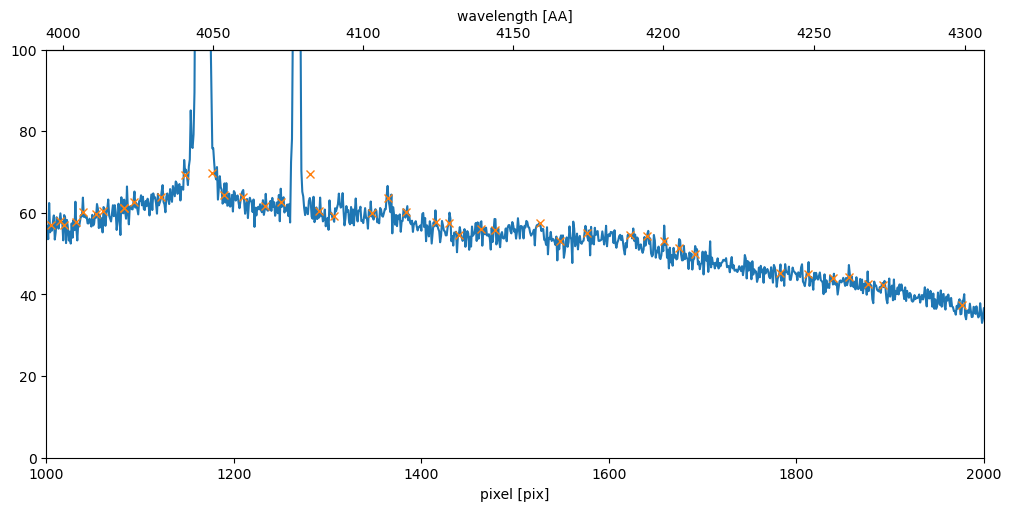

In [30]:
# Blue plot
pixel_array = spec_blue['pix']
wavel_array = spec_blue['lambda']

def forward(x):
    return np.interp(x, pixel_array, wavel_array)

def inverse(x):
    return np.interp(x, wavel_array, pixel_array)

# Plotting
fig, ax = plt.subplots(figsize=[10, 5], layout='constrained')

ax.plot(spec_blue['pix'], spec_blue['flux'], label='Flux Spectrum')
ax.plot(gaus_blue['gaussian peaks'], gaus_blue['amplitudes'], 'x')

ax.set_xlabel('pixel [pix]')

ax.set_ylim(0,100)
ax.set_xlim(1000,2000)

# Secondary axis: Wavelength on top
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('wavelength [AA]')

Text(0.5, 0, 'wavelength [AA]')

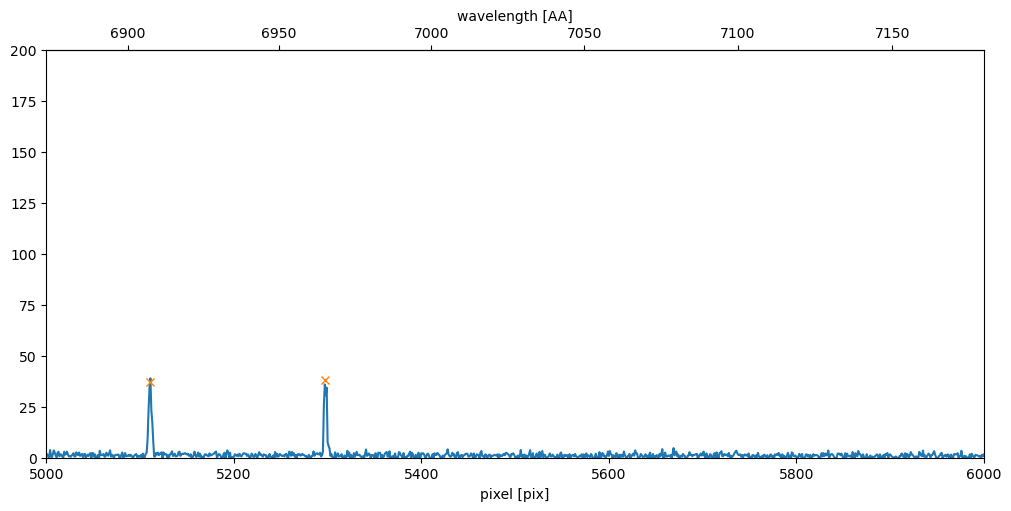

In [42]:
# Green plot
pixel_array = spec_green['pix']
wavel_array = spec_green['lambda']

def forward(x):
    return np.interp(x, pixel_array, wavel_array)

def inverse(x):
    return np.interp(x, wavel_array, pixel_array)

# Plotting
fig, ax = plt.subplots(figsize=[10, 5], layout='constrained')

ax.plot(spec_green['pix'], spec_green['flux'], label='Flux Spectrum')
ax.plot(gaus_green['gaussian peaks'], gaus_green['amplitudes'], 'x')

ax.set_xlabel('pixel [pix]')

ax.set_ylim(0,200)
ax.set_xlim(5000,6000)

# Secondary axis: Wavelength on top
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('wavelength [AA]')